In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'bounded_only'

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
M = 10
orbit_timesteps = 1000
orbit_duration = 1000 # Myr

In [5]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':[],
                'stationary_potential_kwargs_list':[],
                'dynamic_potential_list':['point_source','point_source'],
                'dynamic_potential_kwargs_list':[{'M':10}, {'M':10}],
                'seed':seed,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params):
    env.reset()
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6], orbit.y[agent*6+1], orbit.y[agent*6+2], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6], orbit_delta.y[agent*6+1], orbit_delta.y[agent*6+2], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0], orbit.y[agent*6+1], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0], orbit_delta.y[agent*6+1], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    ax3 = fig.add_subplot(133)
    ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    print(init_params)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0.5, 1.0, 'Initial positions studied, projected on the XY plane')

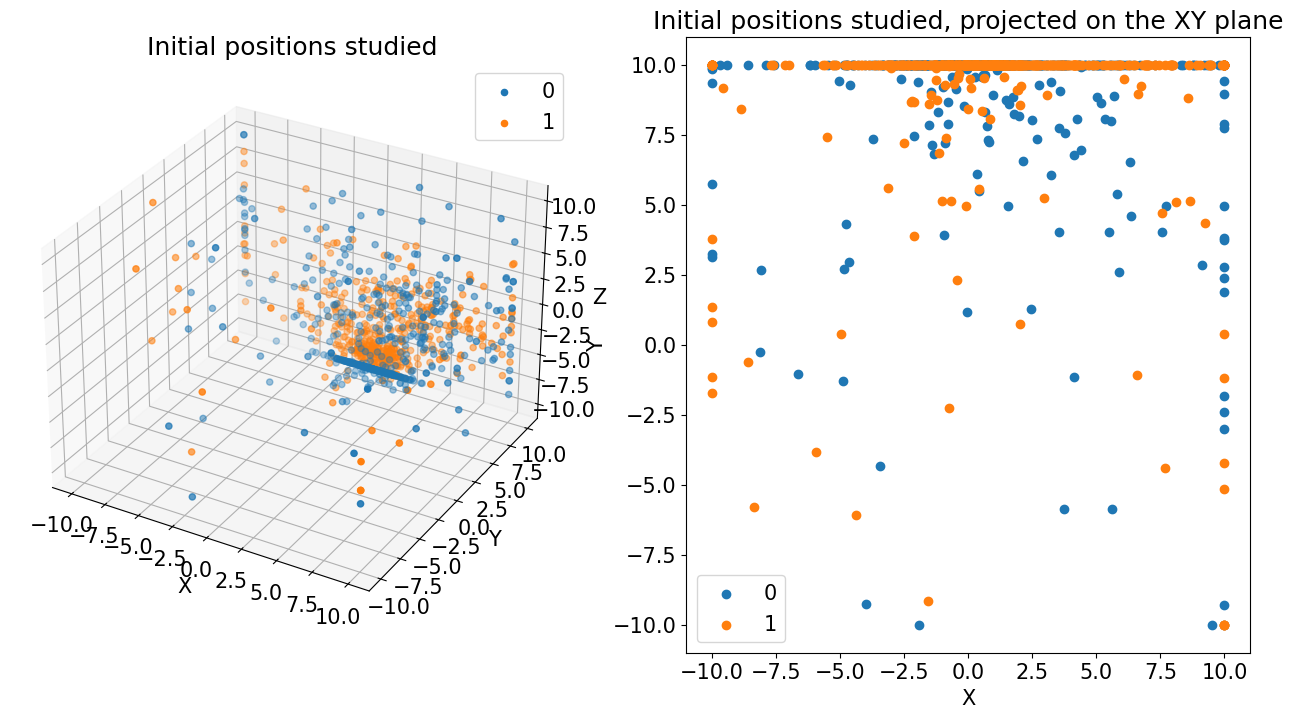

In [6]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('Initial positions studied')

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.set_title('Initial positions studied, projected on the XY plane')

In [7]:
def result_to_init(i):
    return {agent:result_init_params[agent][:,i] for agent in range(env.num_agents)}

{0: np.float64(0.00909188814312204), 1: np.float64(0.008166554387474653)}
{0: array([10.        ,  7.86632013, 10.        , -0.0250167 , -0.03553765,
       -0.01780073]), 1: array([ 10.        , -10.        ,  -3.58932447,  -0.01759754,
        -0.04002254,  -0.01601464])}


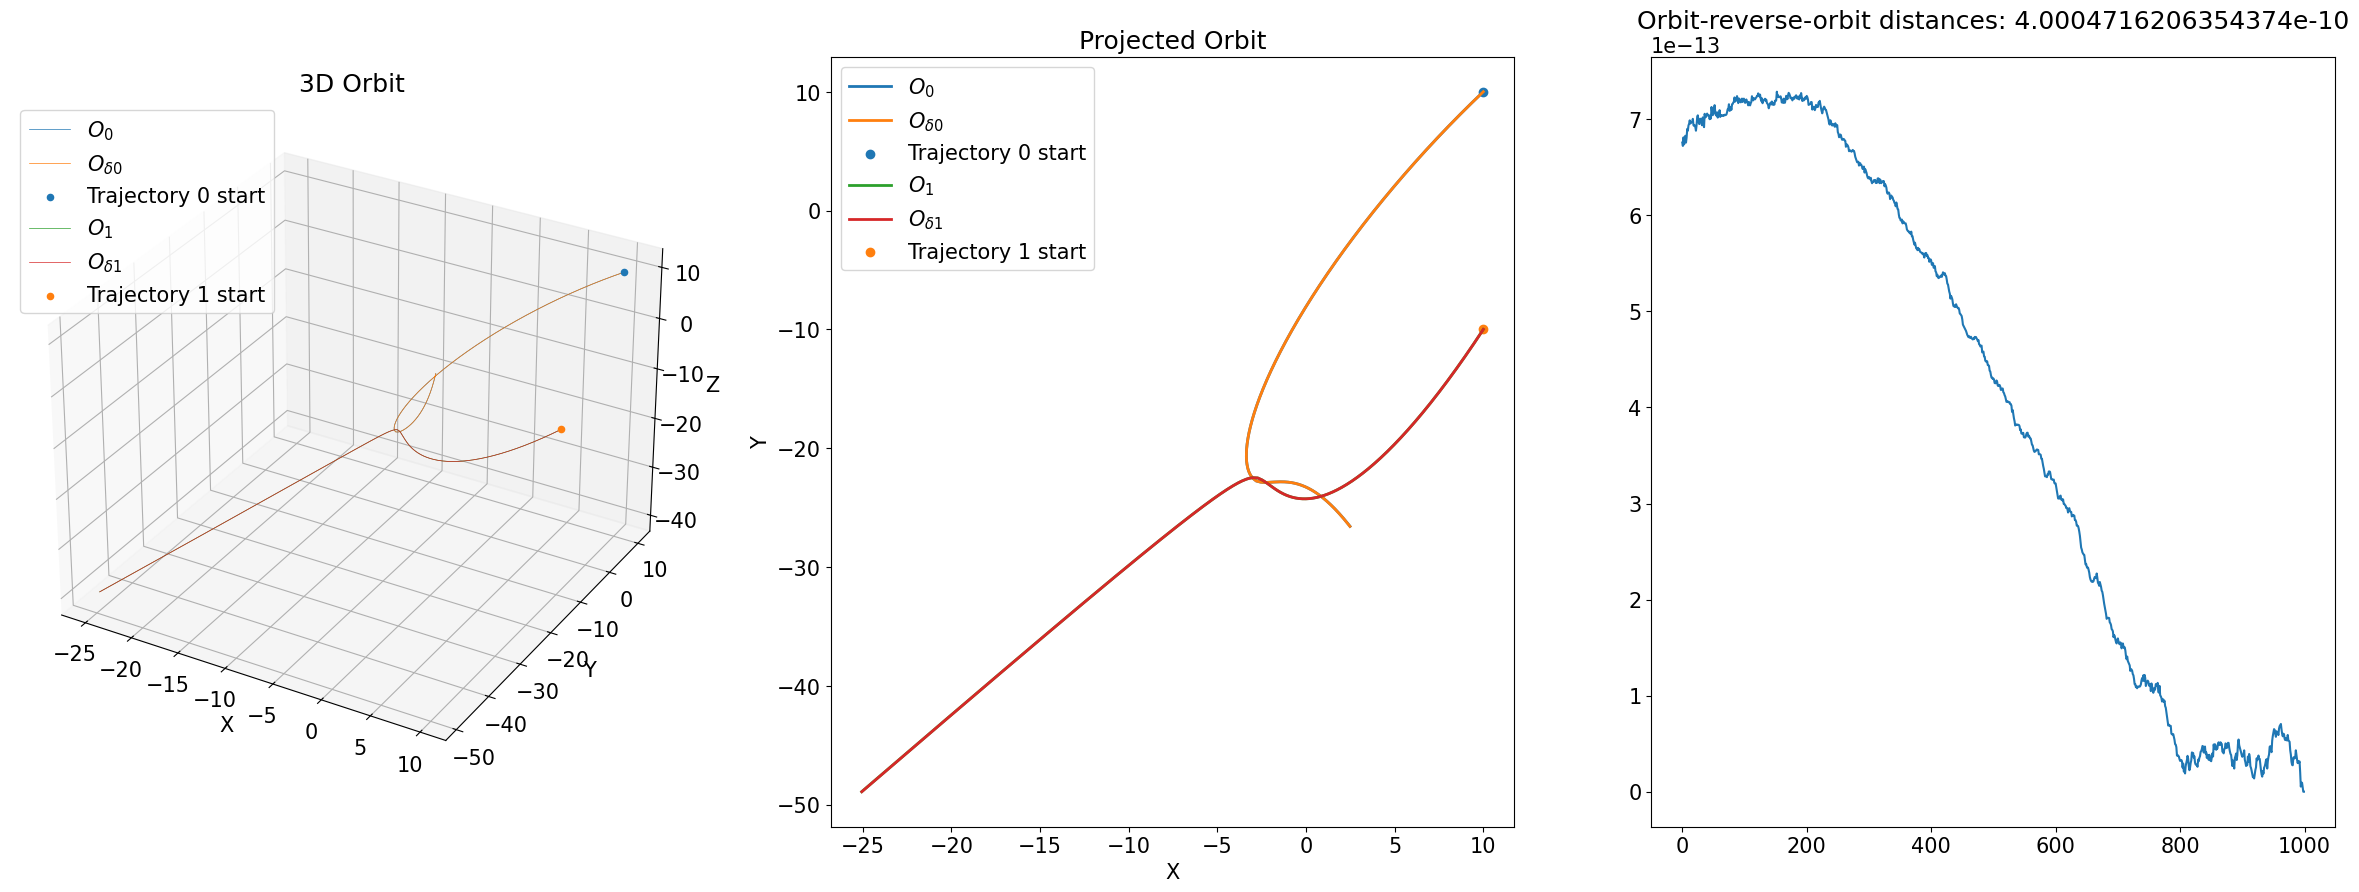

In [8]:
plot_from_init(result_to_init(0))

{0: np.float64(0.0014460709242494789), 1: np.float64(0.0018740202881932975)}
{0: array([ 1.81281865e-01,  1.00000000e+01, -1.00000000e+01, -6.05139211e-02,
        5.22265024e-03, -1.48662359e-01]), 1: array([ 0.88735211, 10.        , -7.98933411, -0.02075766, -0.06060879,
        0.1024318 ])}


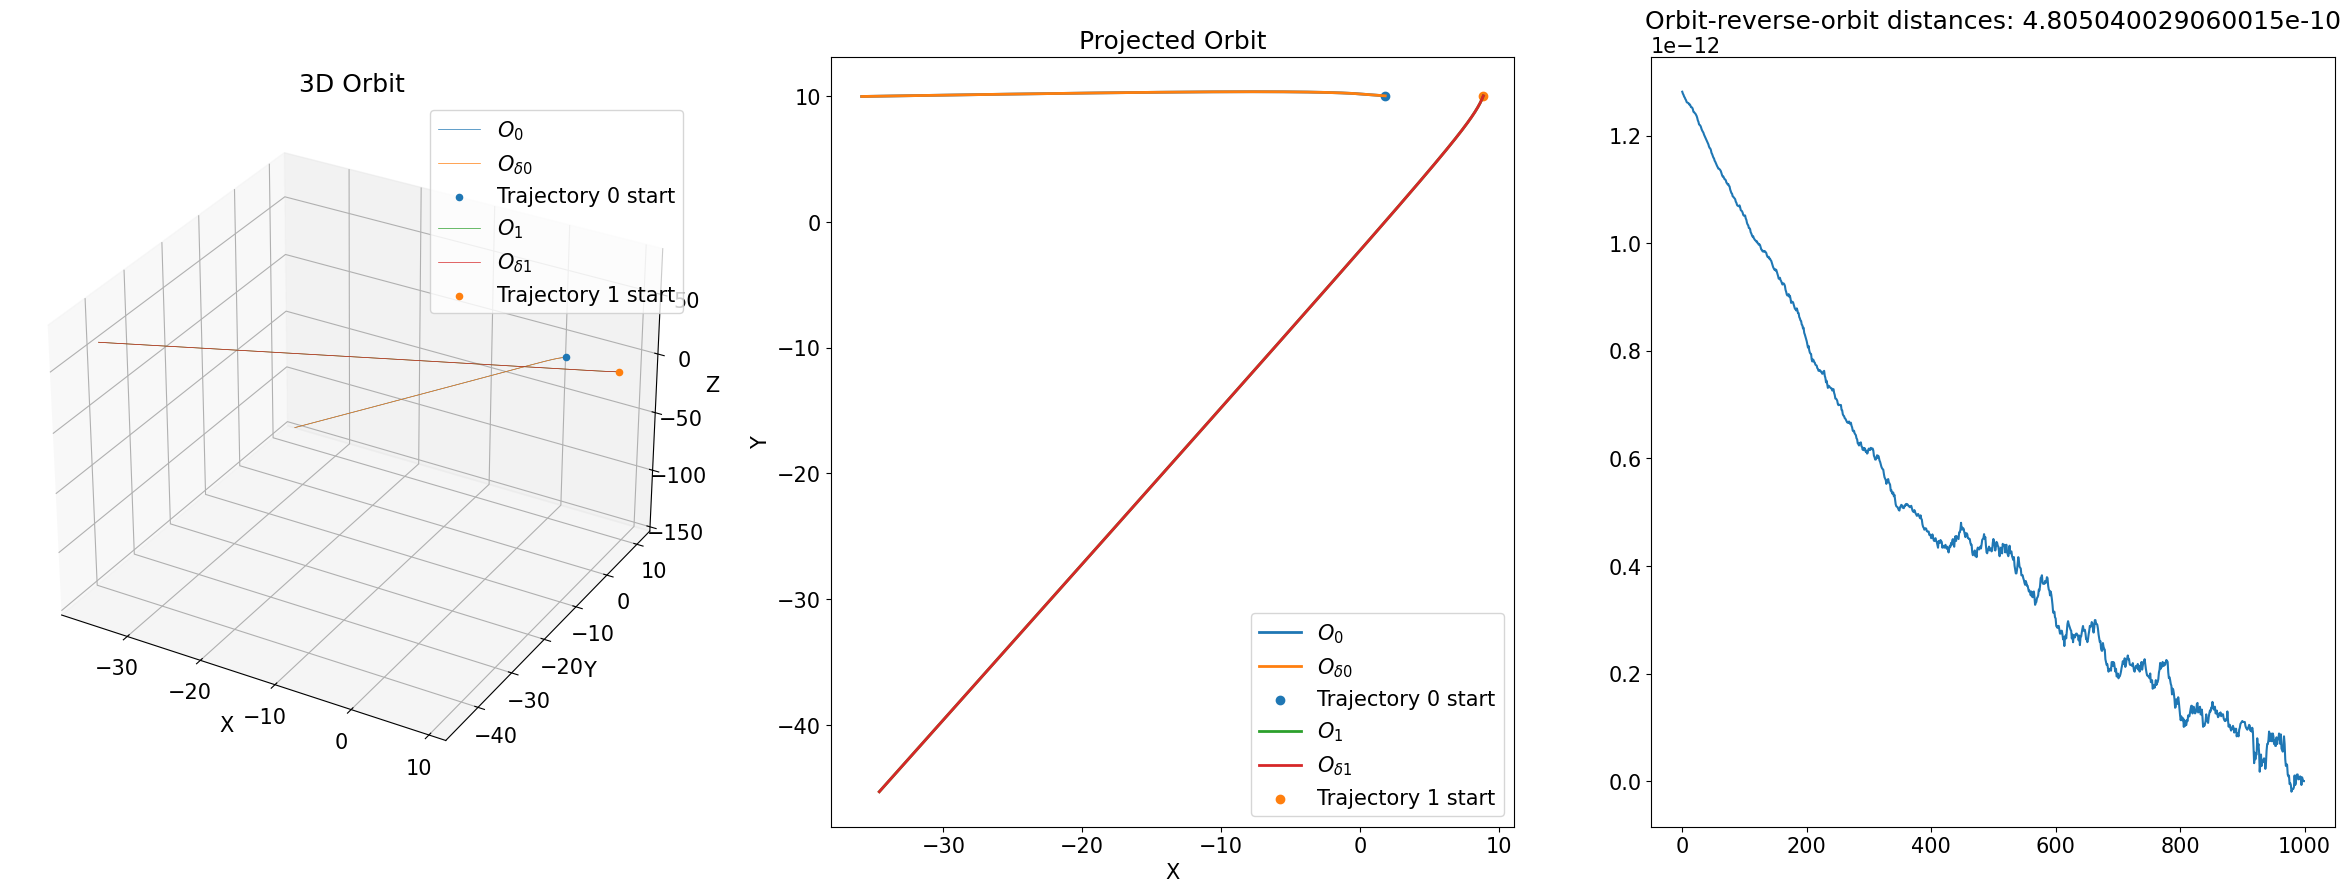

In [9]:
plot_from_init(result_to_init(1))

{0: np.float64(0.0032348591269002074), 1: np.float64(0.0036641734866548923)}
{0: array([ 5.19567299e+00,  8.64020443e+00, -4.09780681e-01,  5.01116216e-02,
       -5.11477049e-03,  6.35968987e-03]), 1: array([ 1.11323476e+00,  1.00000000e+01, -1.74567115e+00, -1.01582907e-01,
        1.02734193e-02,  5.74642094e-03])}


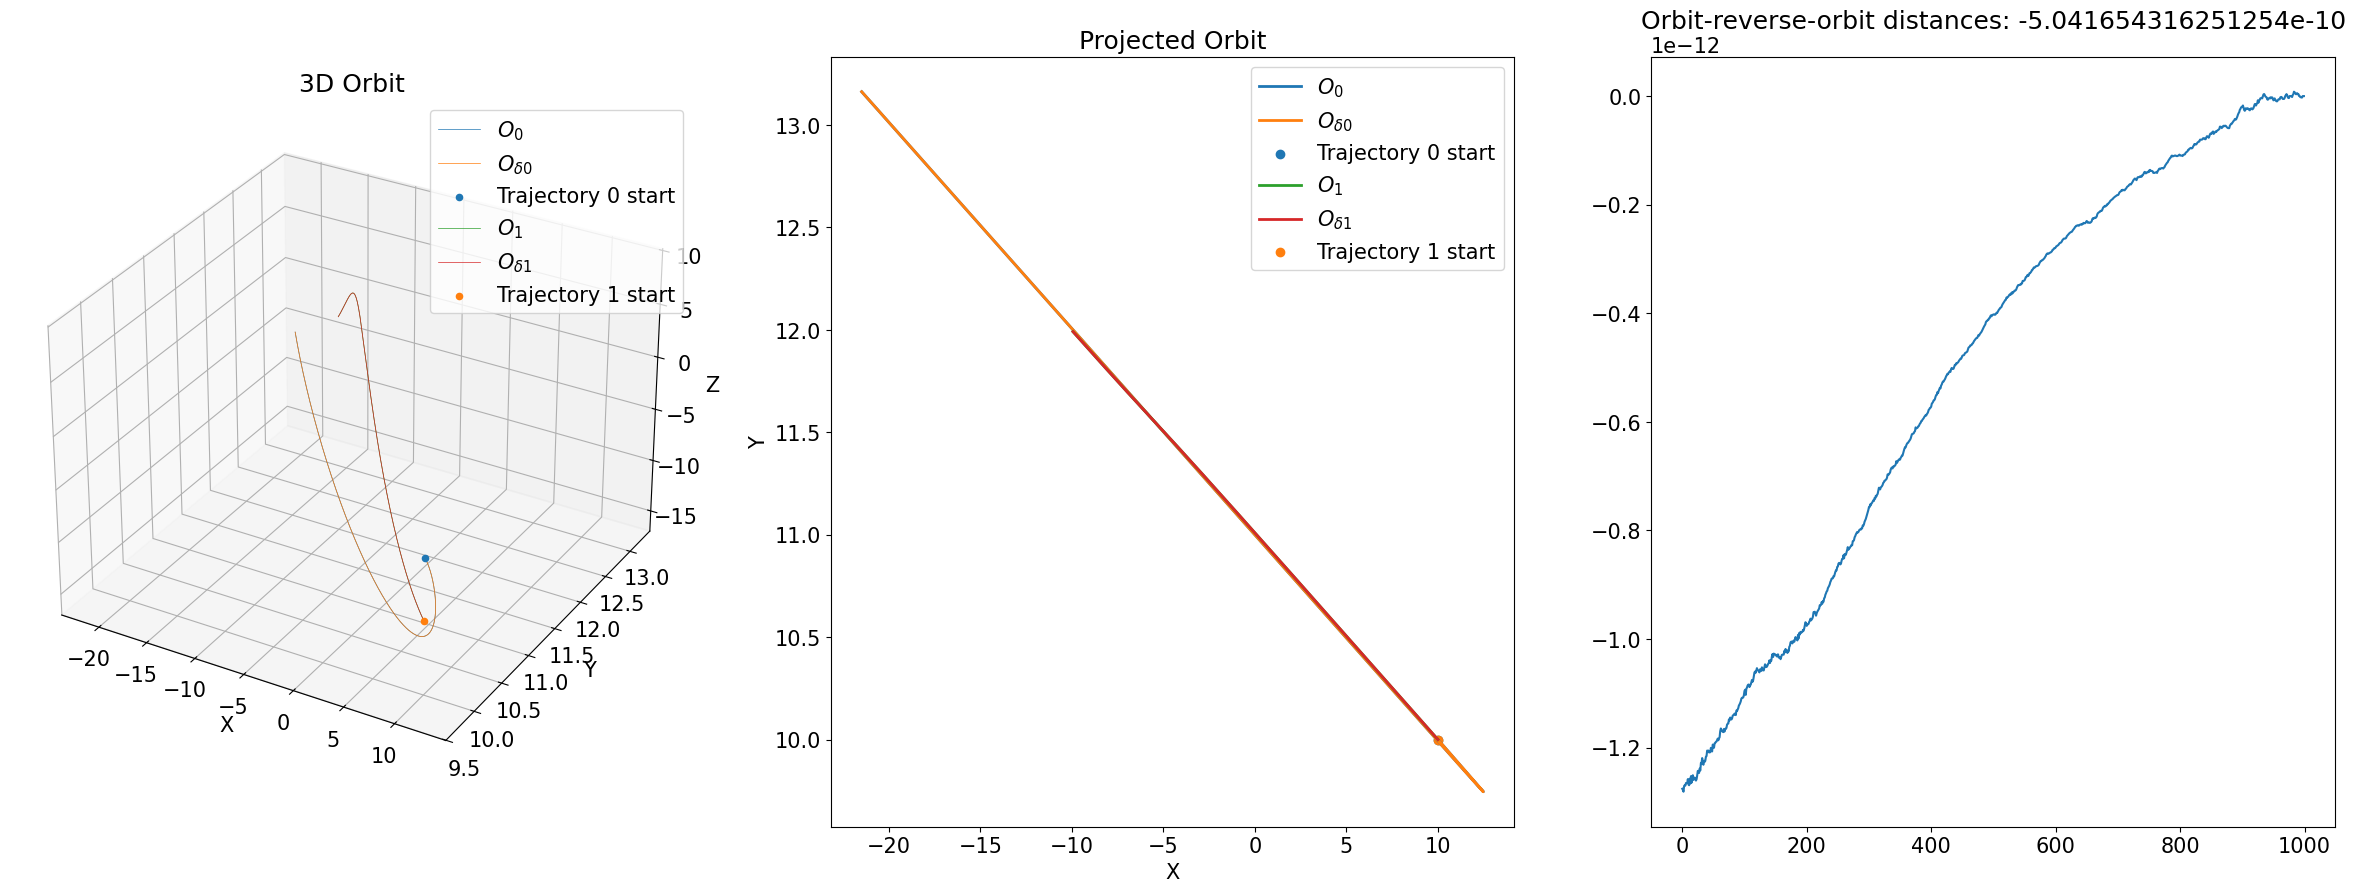

In [10]:
plot_from_init(result_to_init(2))

{0: np.float64(0.0022118551927348615), 1: np.float64(0.002621501871577302)}
{0: array([-1.00000000e+01,  1.00000000e+01,  6.81185126e-01, -6.98978826e-03,
        1.94760468e-02, -4.28387858e-02]), 1: array([-1.14794612e+00,  6.83262777e+00,  4.36521244e+00,  5.99722490e-02,
        2.14359537e-03, -1.52558554e-03])}


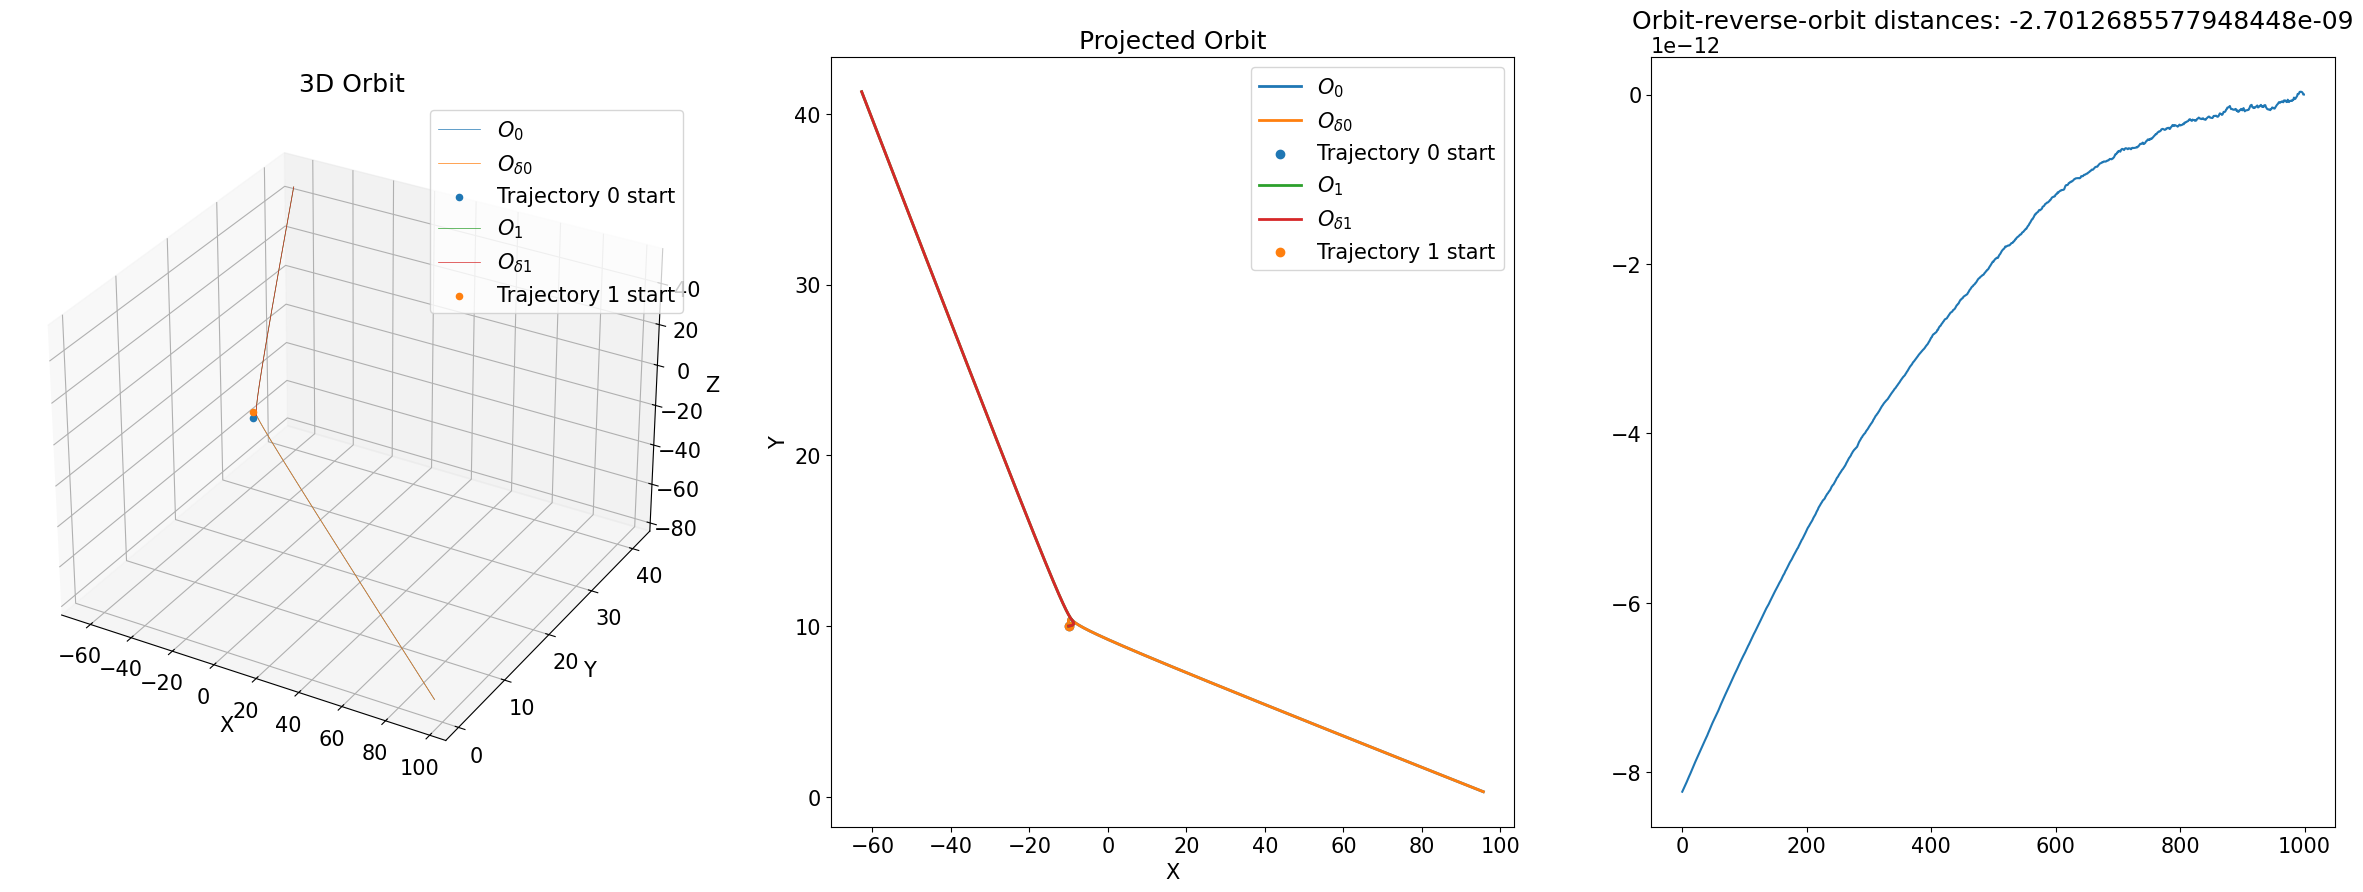

In [11]:
plot_from_init(result_to_init(5))

{0: np.float64(0.0015902315667002207), 1: np.float64(0.0020725022698427466)}
{0: array([  1.59019244,  10.        , -10.        ,   0.10526703,
        -0.07969393,   0.04013501]), 1: array([-2.65486765, 10.        , -6.3626442 ,  0.02067193, -0.05447404,
        0.06045718])}


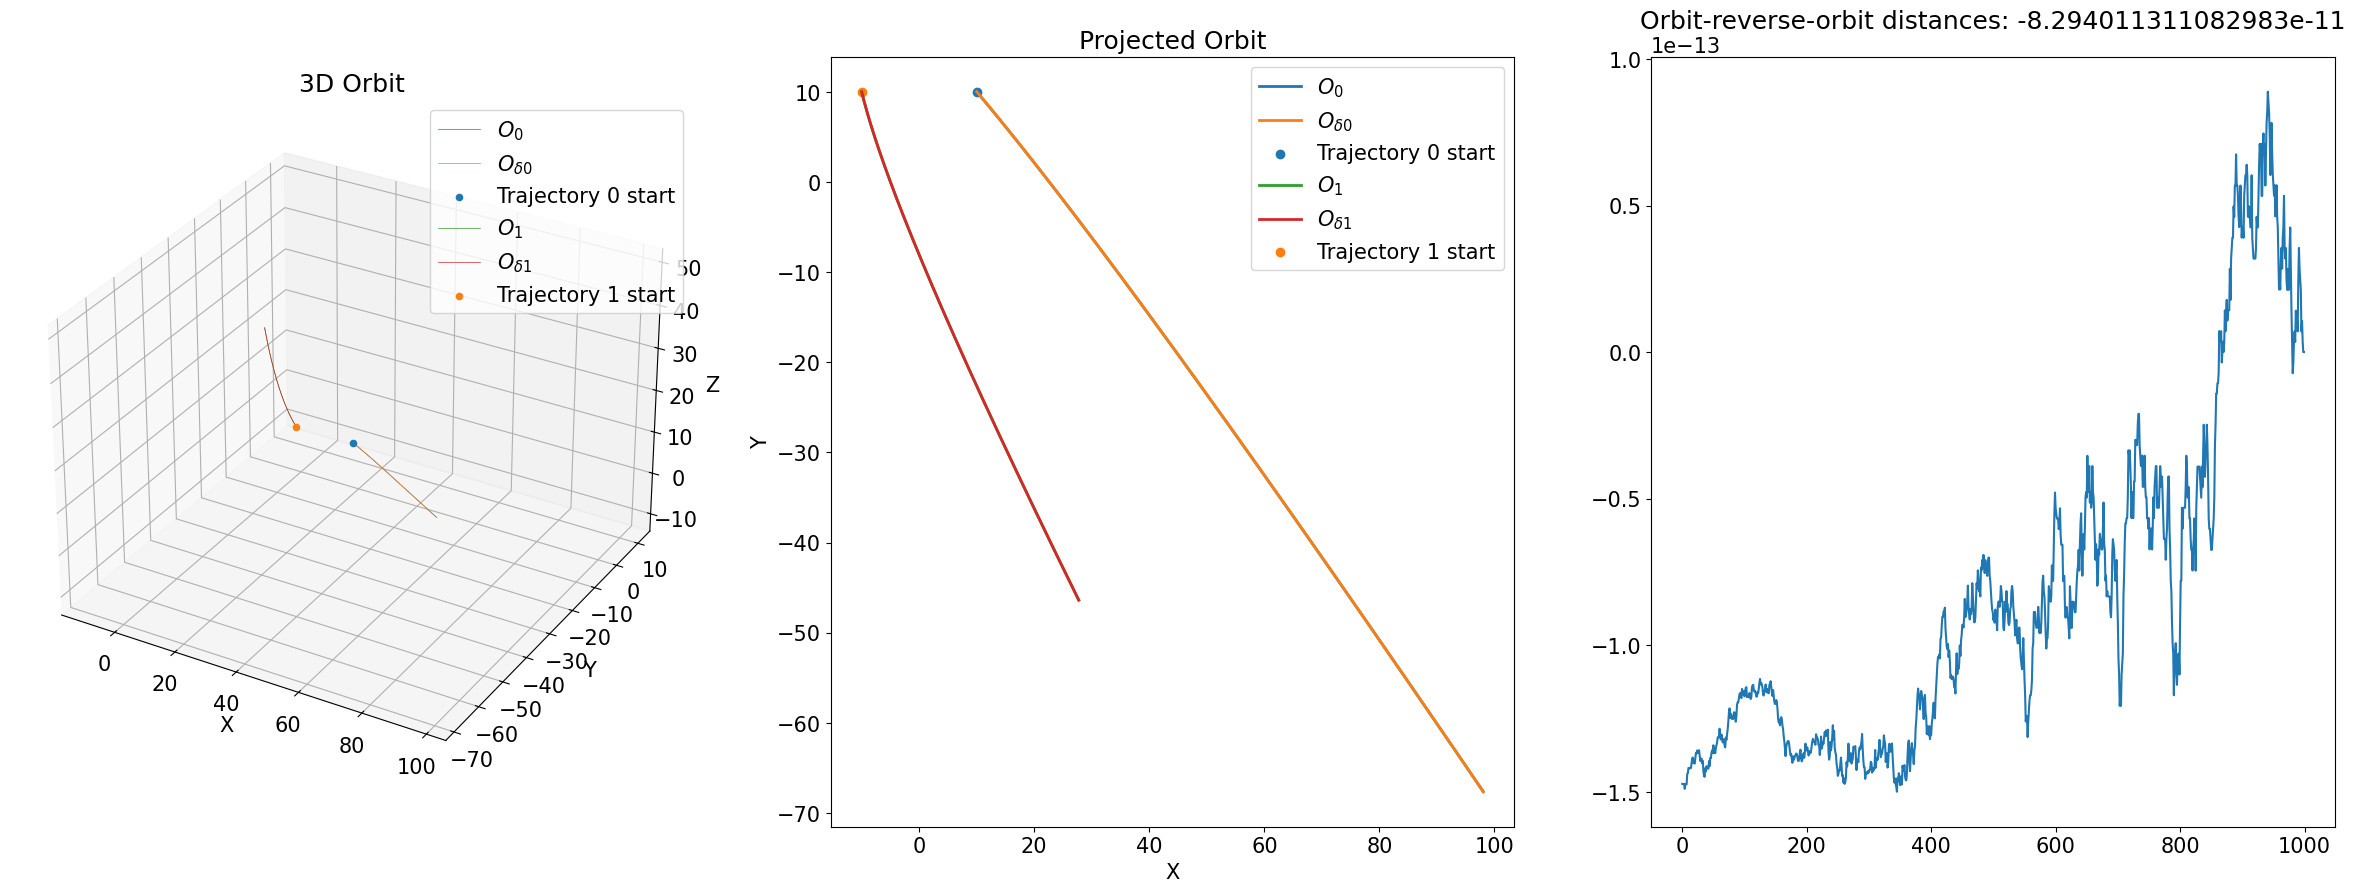

In [12]:
plot_from_init(result_to_init(-1))